In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    confusion_matrix,
)

RANDOM_STATE = 42

ROOT = Path(".")
DATA_DIR = ROOT / "data"
ART_DIR = ROOT / "artifacts"
FIG_DIR = ART_DIR / "figures"
LBL_DIR = ART_DIR / "labels"

for p in [DATA_DIR, ART_DIR, FIG_DIR, LBL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("DATA_DIR:", DATA_DIR.resolve())
print("ART_DIR:", ART_DIR.resolve())


DATA_DIR: C:\Users\Dilvi\Desktop\Mirea-aie-dpo\homeworks\HW07\data
ART_DIR: C:\Users\Dilvi\Desktop\Mirea-aie-dpo\homeworks\HW07\artifacts


In [2]:
DATASETS = {
    "ds1": DATA_DIR / "S07-hw-dataset-01.csv",
    "ds2": DATA_DIR / "S07-hw-dataset-02.csv",
    "ds3": DATA_DIR / "S07-hw-dataset-04.csv",
}

for k, v in DATASETS.items():
    assert v.exists(), f"Файл не найден: {v}"
print("OK: все 3 файла найдены")


OK: все 3 файла найдены


In [4]:
def basic_eda(df: pd.DataFrame, name: str) -> None:
    print(f"=== {name} ===")
    display(df.head())
    display(df.info())
    display(df.describe(include="all").T.head(20))
    miss = df.isna().mean().sort_values(ascending=False)
    print("\nMissing share (top):")
    display(miss.head(15))

def split_X_id(df: pd.DataFrame):
    assert "sample_id" in df.columns, "Ожидается колонка sample_id"
    sample_id = df["sample_id"].copy()
    X = df.drop(columns=["sample_id"]).copy()
    return X, sample_id

def build_preprocessor(X: pd.DataFrame):
    num_cols = X.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]

    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    if len(cat_cols) > 0:
        cat_pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ])
        pre = ColumnTransformer([
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ])
    else:
        pre = ColumnTransformer([
            ("num", num_pipe, num_cols),
        ])

    meta = {"num_cols": num_cols, "cat_cols": cat_cols}
    return pre, meta

def compute_internal_metrics(X_mat, labels, algo_name: str):
    labels = np.asarray(labels)
    uniq = np.unique(labels)

    noise_share = None
    X_eval = X_mat
    labels_eval = labels

    if algo_name.lower().startswith("dbscan"):
        noise_share = float(np.mean(labels == -1))
        mask = labels != -1
        X_eval = X_mat[mask]
        labels_eval = labels[mask]
        uniq_eval = np.unique(labels_eval)
        if len(uniq_eval) < 2:
            return {
                "silhouette": None,
                "davies_bouldin": None,
                "calinski_harabasz": None,
                "noise_share": noise_share,
                "n_clusters": int(len(np.unique(labels[labels != -1]))),
            }

    if len(np.unique(labels_eval)) < 2:
        return {
            "silhouette": None,
            "davies_bouldin": None,
            "calinski_harabasz": None,
            "noise_share": noise_share,
            "n_clusters": int(len(uniq) - (1 if -1 in uniq else 0)),
        }

    return {
        "silhouette": float(silhouette_score(X_eval, labels_eval)),
        "davies_bouldin": float(davies_bouldin_score(X_eval, labels_eval)),
        "calinski_harabasz": float(calinski_harabasz_score(X_eval, labels_eval)),
        "noise_share": noise_share,
        "n_clusters": int(len(uniq) - (1 if -1 in uniq else 0)),
    }

def pca_scatter_save(X_mat, labels, title: str, out_path: Path):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(X_mat)
    plt.figure(figsize=(7, 5))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=16)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()


In [5]:
def kmeans_sweep(X_mat, k_range, random_state=RANDOM_STATE):
    rows = []
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = model.fit_predict(X_mat)
        m = compute_internal_metrics(X_mat, labels, "kmeans")
        rows.append({"k": k, **m})
    return pd.DataFrame(rows)

def plot_metric_vs_k(df_k, metric: str, title: str, out_path: Path):
    plt.figure(figsize=(7, 4))
    plt.plot(df_k["k"], df_k[metric], marker="o")
    plt.title(title)
    plt.xlabel("k")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()


In [6]:
def dbscan_sweep(X_mat, eps_values, min_samples=5):
    rows = []
    for eps in eps_values:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X_mat)
        m = compute_internal_metrics(X_mat, labels, "dbscan")
        rows.append({"eps": float(eps), "min_samples": int(min_samples), **m})
    return pd.DataFrame(rows)

def plot_metric_vs_eps(df_eps, metric: str, title: str, out_path: Path):
    plt.figure(figsize=(7, 4))
    plt.plot(df_eps["eps"], df_eps[metric], marker="o")
    plt.title(title)
    plt.xlabel("eps")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()


=== ds1 (S07-hw-dataset-01.csv) ===


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


None

,count,mean,std,min,25%,50%,75%,max
sample_id,12000.0,5999.500000,3464.245950,0.000000,2999.750000,5999.500000,8999.250000,11999.000000
f01,12000.0,-2.424716,11.014315,-19.912573,-9.472623,-6.869404,0.523841,24.403381
f02,12000.0,19.107804,60.790338,-92.892652,-40.282955,54.069335,70.280739,112.229523
f03,12000.0,-0.222063,0.500630,-1.590979,-0.125145,-0.031753,0.054980,0.512277
f04,12000.0,-8.284501,59.269838,-134.303679,-48.345007,16.211728,28.067178,75.088604
f05,12000.0,-0.190717,7.026435,-11.869169,-5.132473,0.444730,3.942368,13.717091
f06,12000.0,0.962972,14.794713,-20.521164,-8.807706,-6.134169,2.334426,41.452857
f07,12000.0,0.033724,59.541782,-215.098834,-39.900520,-0.578494,39.719821,213.381767
f08,12000.0,0.007638,0.607053,-2.633469,-0.401483,0.005306,0.410132,2.490745



Missing share (top):


sample_id    0.0
f01          0.0
f02          0.0
f03          0.0
f04          0.0
f05          0.0
f06          0.0
f07          0.0
f08          0.0
dtype: float64

Columns meta: {'num_cols': ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08'], 'cat_cols': []}


,k,silhouette,davies_bouldin,calinski_harabasz,noise_share,n_clusters
0,2,0.521640,0.685330,11786.954623,None,2
1,3,0.396758,0.964604,10446.638111,None,3
2,4,0.383301,1.160349,9427.499744,None,4
3,5,0.354801,1.273719,8301.205994,None,5
4,6,0.358561,1.182256,7333.387619,None,6


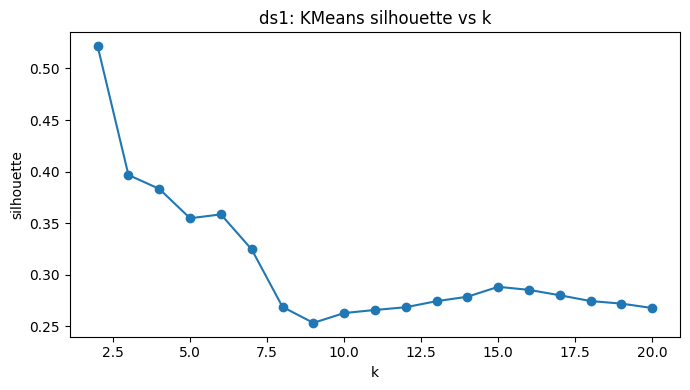

,eps,min_samples,silhouette,davies_bouldin,calinski_harabasz,noise_share,n_clusters
0,0.2,5,-0.259681,1.007256,98.790171,0.874167,62
1,0.4,5,0.005516,0.861784,1428.102018,0.127333,25
2,0.6,5,0.381636,1.251762,8432.692533,0.010833,5
3,0.8,5,0.378711,1.265125,8312.625272,0.001333,5
4,1.0,5,0.383664,1.159076,9456.276998,0.000583,4


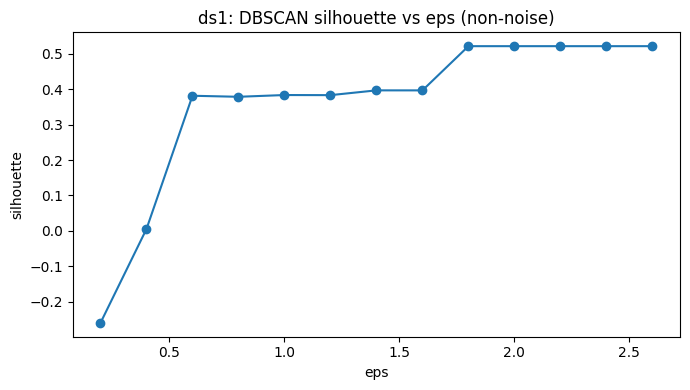

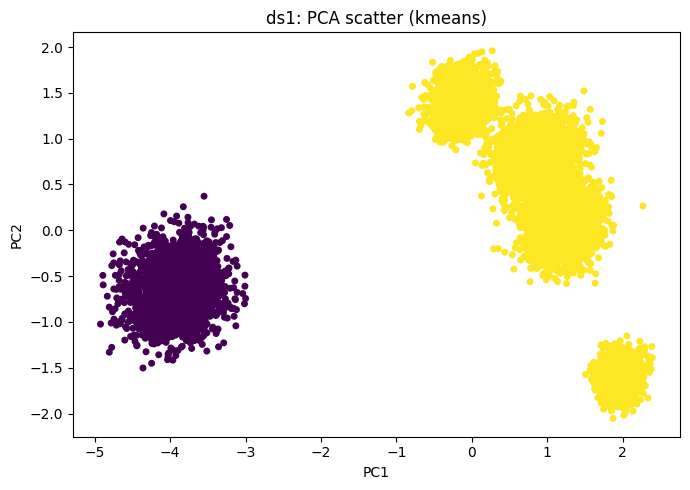

[SAVED] artifacts\labels\labels_hw07_ds1.csv
=== ds2 (S07-hw-dataset-02.csv) ===


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


None

,count,mean,std,min,25%,50%,75%,max
sample_id,8000.0,3999.500000,2309.545410,0.000000,1999.750000,3999.500000,5999.250000,7999.000000
x1,8000.0,0.478867,0.955138,-2.487352,-0.116516,0.490658,1.085263,2.987555
x2,8000.0,0.241112,0.663195,-2.499237,-0.242357,0.241092,0.726526,2.995553
z_noise,8000.0,0.110454,8.097716,-34.056074,-5.392210,0.132470,5.655605,29.460076



Missing share (top):


sample_id    0.0
x1           0.0
x2           0.0
z_noise      0.0
dtype: float64

Columns meta: {'num_cols': ['x1', 'x2', 'z_noise'], 'cat_cols': []}


,k,silhouette,davies_bouldin,calinski_harabasz,noise_share,n_clusters
0,2,0.306861,1.323472,3573.393333,None,2
1,3,0.270045,1.222659,3082.272075,None,3
2,4,0.251481,1.299819,2915.565357,None,4
3,5,0.252115,1.213834,2703.589704,None,5
4,6,0.259820,1.159521,2571.090931,None,6


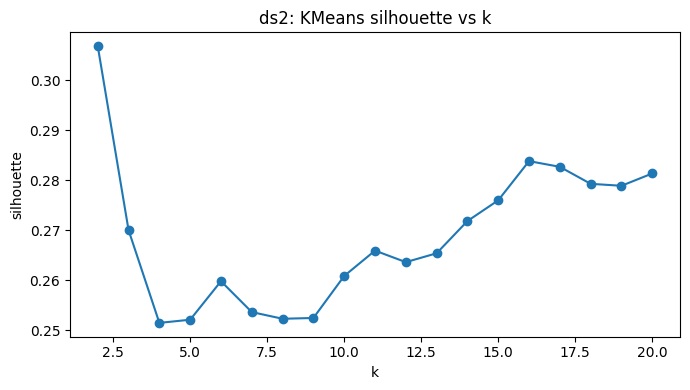

,eps,min_samples,silhouette,davies_bouldin,calinski_harabasz,noise_share,n_clusters
0,0.2,5,-0.035651,0.792408,377.857577,0.102000,9
1,0.4,5,0.134863,0.604157,31.396115,0.061875,8
2,0.6,5,0.138189,0.901970,69.331686,0.022625,12
3,0.8,5,NaN,NaN,NaN,0.005500,1
4,1.0,5,NaN,NaN,NaN,0.001625,1


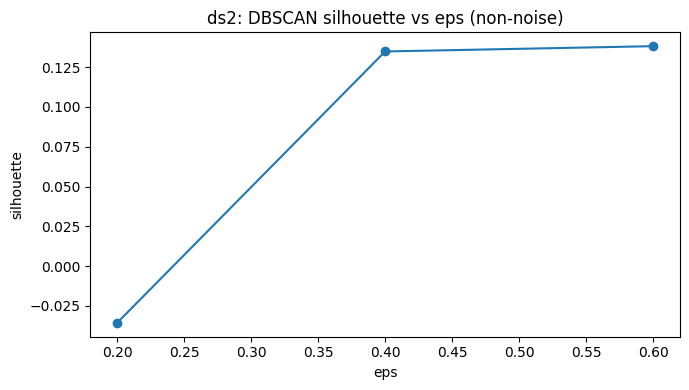

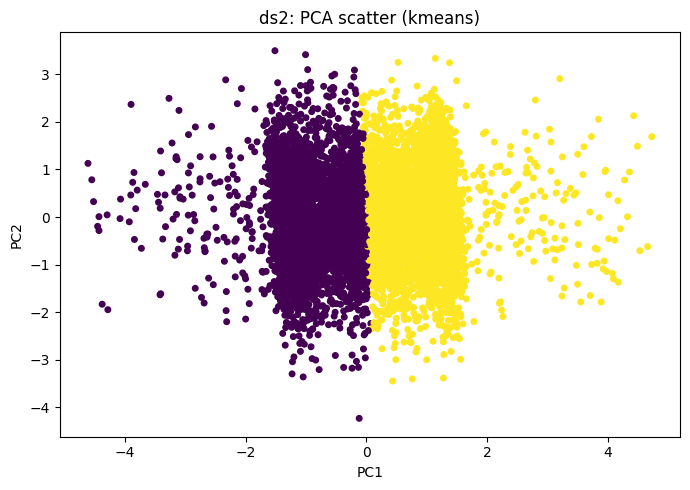

[SAVED] artifacts\labels\labels_hw07_ds2.csv
=== ds3 (S07-hw-dataset-04.csv) ===


,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  10000 non-null  int64  
 1   cat_a      10000 non-null  object 
 2   cat_b      10000 non-null  object 
 3   n01        9826 non-null   float64
 4   n02        9811 non-null   float64
 5   n03        9801 non-null   float64
 6   n04        9808 non-null   float64
 7   n05        9799 non-null   float64
 8   n06        9817 non-null   float64
 9   n07        9796 non-null   float64
 10  n08        9806 non-null   float64
 11  n09        9805 non-null   float64
 12  n10        9811 non-null   float64
 13  n11        9796 non-null   float64
 14  n12        9798 non-null   float64
 15  n13        9803 non-null   float64
 16  n14        9802 non-null   float64
 17  n15        9814 non-null   float64
 18  n16        9809 non-null   float64
 19  n17        9788 non-null   float64
 20  n18    

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sample_id,10000.0,NaN,NaN,NaN,4999.5,2886.89568,0.0,2499.75,4999.5,7499.25,9999.0
cat_a,10000,6,E,1692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cat_b,10000,6,V,1682,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n01,9826.0,NaN,NaN,NaN,17.348435,22.578551,-22.43709,-3.975438,22.042807,37.535647,65.446912
n02,9811.0,NaN,NaN,NaN,-2.05762,19.04341,-37.546998,-14.200552,-6.532183,2.092197,43.326647
n03,9801.0,NaN,NaN,NaN,7.908302,25.637807,-38.136412,-8.591513,0.3504,30.72563,60.185729
n04,9808.0,NaN,NaN,NaN,14.269157,18.815319,-23.374316,-1.223379,10.069142,29.807101,65.094588
n05,9799.0,NaN,NaN,NaN,0.90059,20.981294,-45.91407,-5.086756,2.413111,18.398883,42.527554
n06,9817.0,NaN,NaN,NaN,5.832787,13.221646,-20.650038,-4.532057,7.391953,13.033076,39.933274
n07,9796.0,NaN,NaN,NaN,-0.840875,26.583849,-60.297304,-13.55472,-2.429024,16.095731,48.591236



Missing share (top):


n26    0.0224
n21    0.0215
n18    0.0212
n17    0.0212
n28    0.0211
n24    0.0207
n07    0.0204
n11    0.0204
n20    0.0203
n29    0.0202
n12    0.0202
n05    0.0201
n03    0.0199
n14    0.0198
n27    0.0197
dtype: float64

Columns meta: {'num_cols': ['n01', 'n02', 'n03', 'n04', 'n05', 'n06', 'n07', 'n08', 'n09', 'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19', 'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29', 'n30'], 'cat_cols': ['cat_a', 'cat_b']}


,k,silhouette,davies_bouldin,calinski_harabasz,noise_share,n_clusters
0,2,0.255503,1.635731,3126.328083,None,2
1,3,0.294128,1.466640,3355.136730,None,3
2,4,0.374888,1.164396,3907.022658,None,4
3,5,0.447369,0.975904,5087.688517,None,5
4,6,0.423134,1.009677,5371.618125,None,6


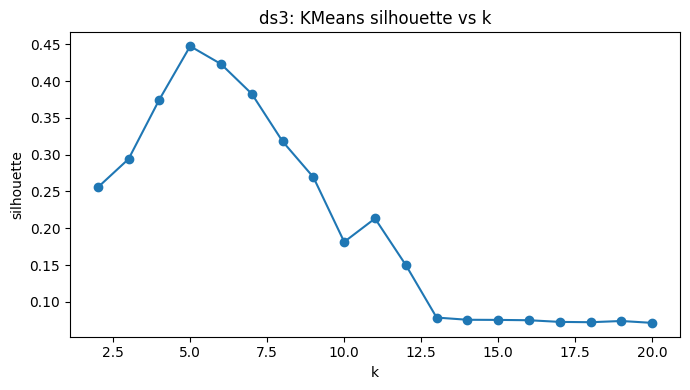

,eps,min_samples,silhouette,davies_bouldin,calinski_harabasz,noise_share,n_clusters
0,0.2,5,NaN,NaN,NaN,1.000,0
1,0.4,5,NaN,NaN,NaN,1.000,0
2,0.6,5,NaN,NaN,NaN,1.000,0
3,0.8,5,NaN,NaN,NaN,1.000,0
4,1.0,5,0.49362,0.701813,15.385195,0.999,2


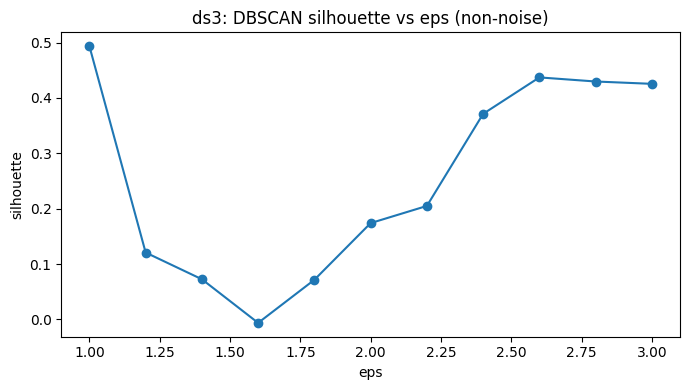

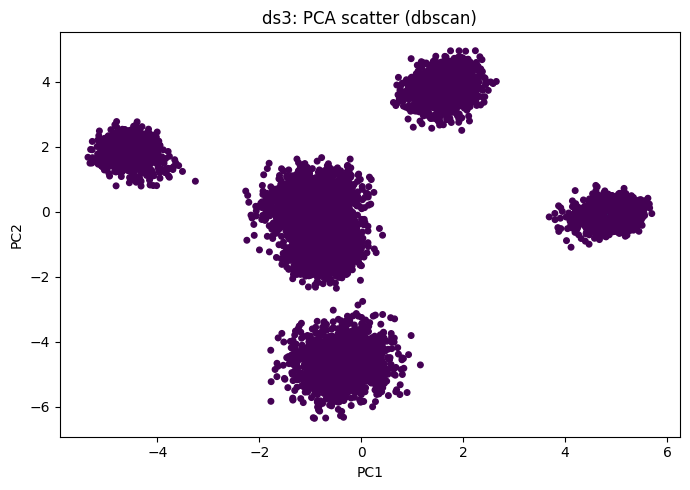

[SAVED] artifacts\labels\labels_hw07_ds3.csv
[SAVED] artifacts\metrics_summary.json
[SAVED] artifacts\best_configs.json


In [7]:
metrics_summary = {}
best_configs = {}

for ds_name, csv_path in DATASETS.items():
    df = pd.read_csv(csv_path)
    basic_eda(df, f"{ds_name} ({csv_path.name})")

    X, sample_id = split_X_id(df)

    pre, meta = build_preprocessor(X)
    X_mat = pre.fit_transform(X)

    if hasattr(X_mat, "toarray"):
        X_mat_dense = X_mat.toarray()
    else:
        X_mat_dense = X_mat

    print("Columns meta:", meta)

    k_range = range(2, 21)
    k_df = kmeans_sweep(X_mat_dense, k_range)
    display(k_df.head())
    plot_metric_vs_k(
        k_df,
        metric="silhouette",
        title=f"{ds_name}: KMeans silhouette vs k",
        out_path=FIG_DIR / f"{ds_name}_kmeans_silhouette_vs_k.png",
    )


    k_df_valid = k_df.dropna(subset=["silhouette"])
    best_k_row = k_df_valid.sort_values("silhouette", ascending=False).iloc[0]
    best_k = int(best_k_row["k"])
    km_best = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
    km_labels = km_best.fit_predict(X_mat_dense)
    km_metrics = compute_internal_metrics(X_mat_dense, km_labels, "kmeans")


    eps_values = np.linspace(0.2, 3.0, 15)
    db_df = dbscan_sweep(X_mat_dense, eps_values, min_samples=5)
    display(db_df.head())


    db_df_valid = db_df.dropna(subset=["silhouette"])
    if not db_df_valid.empty:
        plot_metric_vs_eps(
            db_df_valid,
            metric="silhouette",
            title=f"{ds_name}: DBSCAN silhouette vs eps (non-noise)",
            out_path=FIG_DIR / f"{ds_name}_dbscan_silhouette_vs_eps.png",
        )

        best_db_row = db_df_valid.sort_values("silhouette", ascending=False).iloc[0]
        best_eps = float(best_db_row["eps"])
        db_best = DBSCAN(eps=best_eps, min_samples=5)
        db_labels = db_best.fit_predict(X_mat_dense)
        db_metrics = compute_internal_metrics(X_mat_dense, db_labels, "dbscan")
    else:
        best_eps = None
        db_labels = None
        db_metrics = {
            "silhouette": None,
            "davies_bouldin": None,
            "calinski_harabasz": None,
            "noise_share": None,
            "n_clusters": 0,
        }


    candidates = [
        ("kmeans", {"k": best_k}, km_labels, km_metrics),
    ]
    if best_eps is not None:
        candidates.append(("dbscan", {"eps": best_eps, "min_samples": 5}, db_labels, db_metrics))


    def sil(x):
        v = x[3].get("silhouette")
        return -1e9 if v is None else v

    best_algo, best_params, best_labels, best_m = sorted(candidates, key=sil, reverse=True)[0]


    pca_scatter_save(
        X_mat_dense,
        best_labels,
        title=f"{ds_name}: PCA scatter ({best_algo})",
        out_path=FIG_DIR / f"{ds_name}_best_pca.png",
    )


    out_labels_path = LBL_DIR / f"labels_hw07_{ds_name}.csv"
    pd.DataFrame({"sample_id": sample_id, "cluster_label": best_labels}).to_csv(out_labels_path, index=False)
    print("[SAVED]", out_labels_path)


    metrics_summary[ds_name] = {
        "kmeans_best": {"params": {"k": best_k}, "metrics": km_metrics},
        "dbscan_best": {"params": {"eps": best_eps, "min_samples": 5}, "metrics": db_metrics},
        "winner": {"algo": best_algo, "params": best_params, "metrics": best_m},
        "preprocessing": meta,
    }
    best_configs[ds_name] = {
        "selected_algo": best_algo,
        "selected_params": best_params,
        "selection_criterion": "max_silhouette (DBSCAN метрики считались по non-noise)",
    }


with (ART_DIR / "metrics_summary.json").open("w", encoding="utf-8") as f:
    json.dump(metrics_summary, f, ensure_ascii=False, indent=2)

with (ART_DIR / "best_configs.json").open("w", encoding="utf-8") as f:
    json.dump(best_configs, f, ensure_ascii=False, indent=2)

print("[SAVED]", ART_DIR / "metrics_summary.json")
print("[SAVED]", ART_DIR / "best_configs.json")


In [8]:

STAB_DS = "ds1"
df = pd.read_csv(DATASETS[STAB_DS])
X, _ = split_X_id(df)

pre, _ = build_preprocessor(X)
X_mat = pre.fit_transform(X)
if hasattr(X_mat, "toarray"):
    X_mat = X_mat.toarray()


k_stab = metrics_summary[STAB_DS]["kmeans_best"]["params"]["k"]
seeds = [1, 2, 3, 4, 5]

labels_list = []
for s in seeds:
    km = KMeans(n_clusters=k_stab, random_state=s, n_init=10)
    labels_list.append(km.fit_predict(X_mat))


ref = labels_list[0]
aris = [adjusted_rand_score(ref, lab) for lab in labels_list[1:]]
print(f"Stability KMeans for {STAB_DS}, k={k_stab}")
print("ARI vs seed=1:", aris)
print("Mean ARI:", float(np.mean(aris)))


Stability KMeans for ds1, k=2
ARI vs seed=1: [1.0, 1.0, 1.0, 1.0]
Mean ARI: 1.0


### Итог по ds1
- Победитель: **kmeans**, params={'k': 2}
- Метрики победителя: silhouette=0.5216, DB=0.6853, CH=11786.9546, n_clusters=2, noise_share=None
- Preprocessing: числовых=8, категориальных=0; числовые: median-impute + StandardScaler; категории: most_frequent + OneHotEncoder (если были)
- KMeans(best): k=2, silhouette=0.5216, DB=0.6853, CH=11786.9546
- DBSCAN(best): eps=1.8000, min_samples=5, silhouette=0.5216, DB=0.6853, CH=11786.9546, noise_share=0.0000, n_clusters=2
- Замечание: признаки в разных шкалах, поэтому масштабирование критично. KMeans показывает высокий силуэт при малом k, что соответствует “шарообразной” структуре.
- Устойчивость: для KMeans при k=2 ARI между запусками = 1.0 (идеально совпадают разбиения), значит кластеризация стабильна к random_state.

### Итог по ds2
- Победитель: **kmeans**, params={'k': 2}
- Метрики победителя: silhouette=0.3069, DB=1.3235, CH=3573.3933, n_clusters=2, noise_share=None
- Preprocessing: числовых=3, категориальных=0; числовые: median-impute + StandardScaler; категории: most_frequent + OneHotEncoder (если были)
- KMeans(best): k=2, silhouette=0.3069, DB=1.3235, CH=3573.3933
- DBSCAN(best): eps=0.6000, min_samples=5, silhouette=0.1382, DB=0.9020, CH=69.3317, noise_share=0.0226, n_clusters=12
- Замечание: структура нелинейная/шумовая, поэтому силуэт у KMeans умеренный. DBSCAN может выделять локальные плотности, но чувствителен к eps и может давать шум.

### Итог по ds3
- Победитель: **dbscan**, params={'eps': 1.0, 'min_samples': 5}
- Метрики победителя: silhouette=0.4936, DB=0.7018, CH=15.3852, n_clusters=2, noise_share=0.9990
- Preprocessing: числовых=30, категориальных=2; числовые: median-impute + StandardScaler; категории: most_frequent + OneHotEncoder (если были)
- KMeans(best): k=5, silhouette=0.4474, DB=0.9759, CH=5087.6885
- DBSCAN(best): eps=1.0000, min_samples=5, silhouette=0.4936, DB=0.7018, CH=15.3852, noise_share=0.9990, n_clusters=2
- Замечание: DBSCAN почти полностью пометил точки как шум (noise_share≈1.0), поэтому метрики часто не определены или считаются по очень малому числу non-noise точек. Для этого датасета более уместен KMeans после корректного препроцессинга (impute+scaling+OHE).